In [155]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from xgboost import XGBRegressor
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [156]:
data = pd.read_csv('processed_datasets/GMSL_analysis_and_prediction.csv', delimiter=',')

In [157]:
data.head().append(data.tail())

,Date,Extent,WaterTemp,O2ml,SiO3,NO3,LandAverageTemperature,LandAndOceanAverageTemperature,CO2,IsGMSLIncreased,GMSL
0,1969-01,11.412998,13.265000,5.595000,7.00000,3.250,1.966,13.518,324.00,0,-35.8
1,1969-02,11.419180,12.435000,5.695000,6.40000,5.200,2.450,13.747,324.42,0,-37.2
2,1969-03,11.425310,15.535000,5.490000,4.00000,0.300,5.131,14.576,325.64,1,-36.2
3,1969-04,11.431388,12.070000,5.312500,8.50000,6.400,8.576,15.518,326.66,0,-37.4
4,1969-05,11.437415,12.120000,5.945000,6.00000,3.700,11.354,16.329,327.34,0,-38.6
535,2013-08,12.338645,12.053062,5.263625,7.47125,8.925,14.742,17.462,395.20,1,71.6
536,2013-09,12.298467,12.200875,5.302750,6.75750,8.100,13.154,16.894,393.45,0,68.8
537,2013-10,13.236306,12.348688,5.341875,6.04375,7.275,10.256,15.905,393.70,0,66.4
538,2013-11,13.405600,12.496500,5.381000,5.33000,6.450,7.424,15.107,395.16,0,59.7
539,2013-12,13.066000,13.062250,5.427250,4.62625,4.275,4.724,14.339,396.84,0,58.5


In [158]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data.sort_index()
data

,Extent,WaterTemp,O2ml,SiO3,NO3,LandAverageTemperature,LandAndOceanAverageTemperature,CO2,IsGMSLIncreased,GMSL
Date,,,,,,,,,,
1969-01-01,11.412998,13.265000,5.595000,7.00000,3.250,1.966,13.518,324.00,0,-35.8
1969-02-01,11.419180,12.435000,5.695000,6.40000,5.200,2.450,13.747,324.42,0,-37.2
1969-03-01,11.425310,15.535000,5.490000,4.00000,0.300,5.131,14.576,325.64,1,-36.2
1969-04-01,11.431388,12.070000,5.312500,8.50000,6.400,8.576,15.518,326.66,0,-37.4
1969-05-01,11.437415,12.120000,5.945000,6.00000,3.700,11.354,16.329,327.34,0,-38.6
...,...,...,...,...,...,...,...,...,...,...
2013-08-01,12.338645,12.053062,5.263625,7.47125,8.925,14.742,17.462,395.20,1,71.6
2013-09-01,12.298467,12.200875,5.302750,6.75750,8.100,13.154,16.894,393.45,0,68.8
2013-10-01,13.236306,12.348688,5.341875,6.04375,7.275,10.256,15.905,393.70,0,66.4


In [159]:
# Split train-val-test
# ==============================================================================
end_train = '2008-12-01'
end_validation = '2011-12-01'
data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Dates train      : 1969-01-01 00:00:00 --- 2008-12-01 00:00:00  (n=480)
Dates validacion : 2008-12-01 00:00:00 --- 2011-12-01 00:00:00  (n=37)
Dates test       : 2011-12-01 00:00:00 --- 2013-12-01 00:00:00  (n=25)


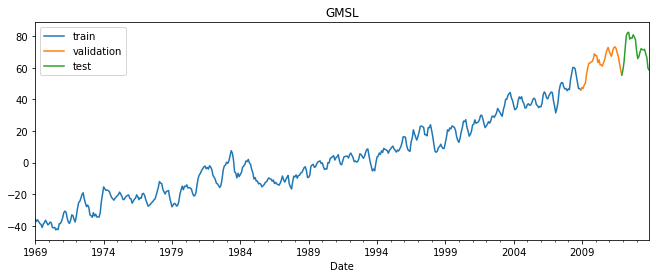

In [160]:
fig, ax = plt.subplots(figsize=(11, 4))
data_train['GMSL'].plot(ax=ax, label='train')
data_val['GMSL'].plot(ax=ax, label='validation')
data_test['GMSL'].plot(ax=ax, label='test')
ax.set_title('GMSL')
ax.legend()

In [161]:
# Interactive plot of time series
# ==============================================================================
data.loc[:end_train, 'partition'] = 'train'
data.loc[end_train:end_validation, 'partition'] = 'validation'
data.loc[end_validation:, 'partition'] = 'test'

fig = px.line(
    data_frame = data.reset_index(),
    x      = 'Date',
    y      = 'GMSL',
    color  = 'partition',
    title  = 'GMSL',
    width  = 900,
    height = 500
)

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

data=data.drop(columns='partition')

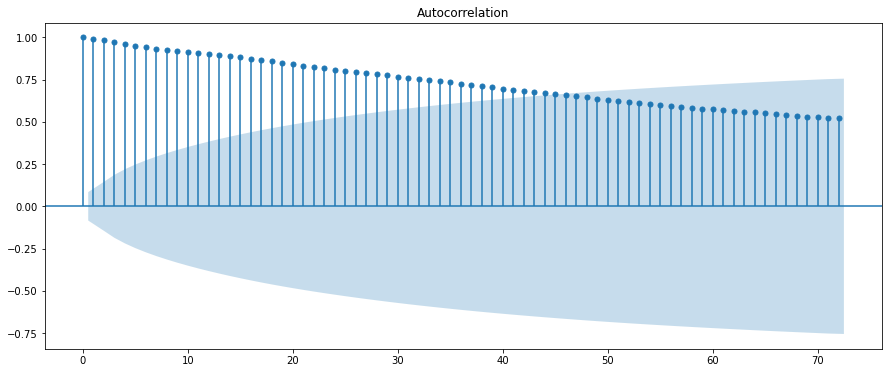

In [162]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(data['GMSL'], ax=ax, lags=72)
plt.show()

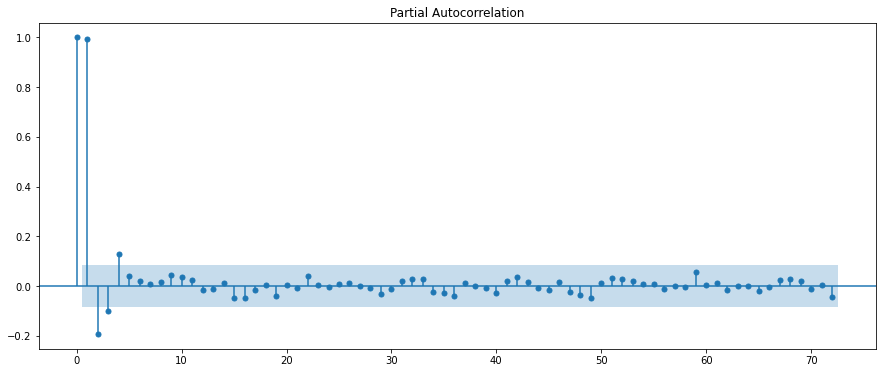

In [163]:
# Partial autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(data['GMSL'], ax=ax, lags=72, method='ywm')
plt.show()

In [164]:
exog_variables = [column for column in data.columns
                      if column.startswith(('Extent', 'WaterTemp', 'O2ml', 'SiO3', 'NO3', 'LandAverageTemperature', 'LandAndOceanAverageTemperature', 'CO2'))]
print(exog_variables)

['Extent', 'WaterTemp', 'O2ml', 'SiO3', 'NO3', 'LandAverageTemperature', 'LandAndOceanAverageTemperature', 'CO2']


In [165]:
# Create forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123),
                lags = 8
             )

In [166]:
# Grid search of hyperparameters and lags
# ==============================================================================
# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100, 500],
    'max_depth': [3, 5, 6, 10],
    'learning_rate': [0.01, 0.1]
}

# Lags used as predictors
#lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]
lags_grid = [3, 10, [1, 2, 3, 20]]

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data.loc[:end_validation, 'GMSL'],
                        exog               = data.loc[:end_validation, exog_variables],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 1,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)),
                        return_best        = True,
                        verbose            = False
                   )
# best 56.2972068648576

# param_grid = {
#     'n_estimators': [20, 50, 75, 100, 300, 500],
#     'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25],
#     'learning_rate': [0.01, 0.02, 0.1]
# }

# # Lags used as predictors
# #lags_grid = [72, [1, 2, 3, 23, 24, 25, 71, 72, 73]]
# lags_grid = [3, 5, 10, [1, 2, 3, 4, 6, 10, 16, 20]]

# results_grid = grid_search_forecaster(
#                         forecaster         = forecaster,
#                         y                  = data.loc[:end_validation, 'GMSL'],
#                         exog               = data.loc[:end_validation, exog_variables],
#                         param_grid         = param_grid,
#                         lags_grid          = lags_grid,
#                         steps              = 1,
#                         refit              = False,
#                         metric             = 'mean_squared_error',
#                         initial_train_size = int(len(data_train)),
#                         return_best        = True,
#                         verbose            = False
#                    )

# best 53.482526615700706

Number of models compared: 72


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:27<00:00, 29.13s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 70.80228547682303



In [167]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
    forecaster         = forecaster,
    y                  = data['GMSL'],
    exog               = data[exog_variables],
    initial_train_size = len(data.loc[:end_validation])-1,
    steps              = 1,
    refit              = False,
    metric             = 'mean_squared_error',
    verbose            = False
)

print(f"Backtest error: {metric}")

Backtest error: 56.2972068648576


In [168]:
importance = forecaster.get_feature_importance()
importance

,feature,importance
0,lag_1,0.946348
1,lag_2,0.001085
2,lag_3,0.000963
3,lag_4,0.000406
4,lag_5,0.001531
5,lag_6,0.001603
6,lag_7,0.002795
7,lag_8,0.008277
8,lag_9,0.001874
9,lag_10,0.013336


In [169]:
# Predictions
# ==============================================================================
#predictions

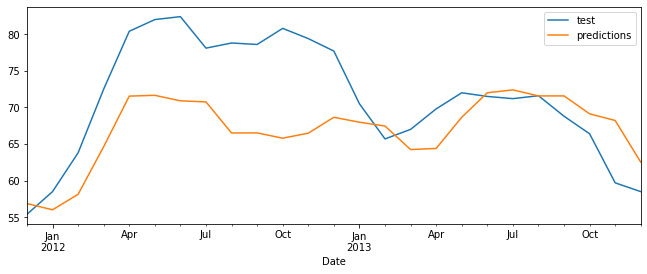

In [170]:
# Plot of predictions
# ==============================================================================
fig, ax = plt.subplots(figsize=(11, 4))
data_test['GMSL'].plot(ax=ax, label='test')
predictions['pred'].plot(ax=ax, label='predictions')
ax.legend();

In [171]:
predictions['pred']

2011-12-01    56.872383
2012-01-01    56.016464
2012-02-01    58.133602
2012-03-01    64.637260
2012-04-01    71.544617
2012-05-01    71.654991
2012-06-01    70.901321
2012-07-01    70.758163
2012-08-01    66.509651
2012-09-01    66.523705
2012-10-01    65.797508
2012-11-01    66.481636
2012-12-01    68.653633
2013-01-01    67.980553
2013-02-01    67.462547
2013-03-01    64.246880
2013-04-01    64.399742
2013-05-01    68.653557
2013-06-01    72.000160
2013-07-01    72.396645
2013-08-01    71.571686
2013-09-01    71.576088
2013-10-01    69.124802
2013-11-01    68.217438
2013-12-01    62.520317
Freq: MS, Name: pred, dtype: float64

In [172]:
data_test['GMSL']

Date
2011-12-01    55.4
2012-01-01    58.5
2012-02-01    63.8
2012-03-01    72.5
2012-04-01    80.4
2012-05-01    82.0
2012-06-01    82.4
2012-07-01    78.1
2012-08-01    78.8
2012-09-01    78.6
2012-10-01    80.8
2012-11-01    79.4
2012-12-01    77.7
2013-01-01    70.5
2013-02-01    65.7
2013-03-01    67.0
2013-04-01    69.8
2013-05-01    72.0
2013-06-01    71.5
2013-07-01    71.2
2013-08-01    71.6
2013-09-01    68.8
2013-10-01    66.4
2013-11-01    59.7
2013-12-01    58.5
Freq: MS, Name: GMSL, dtype: float64

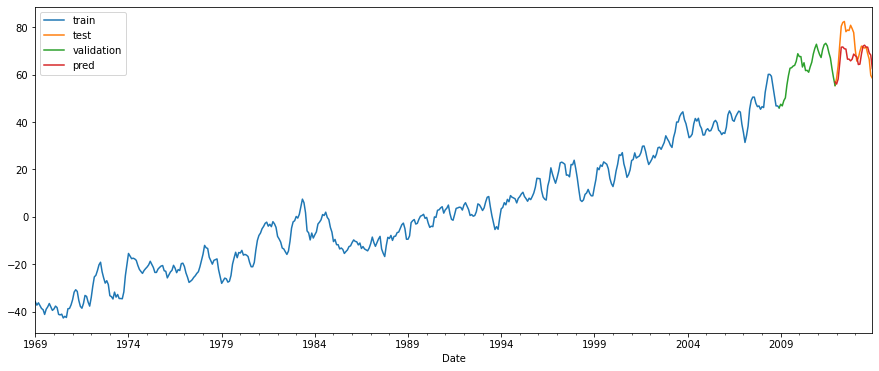

In [173]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(15, 6))
data_train['GMSL'].plot(ax=ax, label='train')
data_test['GMSL'].plot(ax=ax, label='test')
data_val['GMSL'].plot(ax=ax, label='validation')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [174]:
data_test.insert(len(data_test.columns), 'GMSL_PREDICTION', predictions['pred'])

In [175]:
data_test.head()

,Extent,WaterTemp,O2ml,SiO3,NO3,LandAverageTemperature,LandAndOceanAverageTemperature,CO2,IsGMSLIncreased,GMSL,GMSL_PREDICTION
Date,,,,,,,,,,,
2011-12-01,11.676274,12.355,4.825,8.500,8.700,4.655,14.198,391.86,0,55.4,56.872383
2012-01-01,9.691645,13.900,5.640,2.600,0.600,3.157,13.859,393.12,1,58.5,56.016464
2012-02-01,9.053293,12.160,5.410,5.825,5.525,3.628,14.164,393.86,1,63.8,58.133602
2012-03-01,9.873258,11.750,5.495,10.000,10.400,6.023,14.863,394.40,1,72.5,64.637260
2012-04-01,10.967500,10.660,4.990,19.000,17.300,9.676,15.881,396.18,1,80.4,71.544617


In [176]:
data_test.insert(len(data_test.columns), 'Error', data_test['GMSL'] - data_test['GMSL_PREDICTION'])
data_test.insert(len(data_test.columns), 'Abs_error', data_test['Error'].apply(np.abs))

In [177]:
error_by_day = data_test.groupby(['Date']).mean()[['GMSL','GMSL_PREDICTION','Error','Abs_error']]

In [178]:
# Worst absolute predicted days
error_by_day.sort_values('Abs_error', ascending=False).head(10)

,GMSL,GMSL_PREDICTION,Error,Abs_error
Date,,,,
2012-10-01,80.8,65.797508,15.002492,15.002492
2012-11-01,79.4,66.481636,12.918364,12.918364
2012-08-01,78.8,66.509651,12.290349,12.290349
2012-09-01,78.6,66.523705,12.076295,12.076295
2012-06-01,82.4,70.901321,11.498679,11.498679
2012-05-01,82.0,71.654991,10.345009,10.345009
2012-12-01,77.7,68.653633,9.046367,9.046367
2012-04-01,80.4,71.544617,8.855383,8.855383
2013-11-01,59.7,68.217438,-8.517438,8.517438


In [179]:
# Best predicted days
error_by_day.sort_values('Abs_error', ascending=True).head(10)

,GMSL,GMSL_PREDICTION,Error,Abs_error
Date,,,,
2013-08-01,71.6,71.571686,0.028314,0.028314
2013-06-01,71.5,72.000160,-0.500160,0.500160
2013-07-01,71.2,72.396645,-1.196645,1.196645
2011-12-01,55.4,56.872383,-1.472383,1.472383
2013-02-01,65.7,67.462547,-1.762547,1.762547
2012-01-01,58.5,56.016464,2.483536,2.483536
2013-01-01,70.5,67.980553,2.519447,2.519447
2013-10-01,66.4,69.124802,-2.724802,2.724802
2013-03-01,67.0,64.246880,2.753120,2.753120


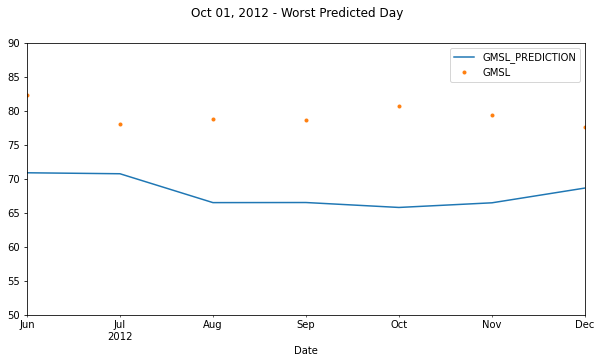

In [180]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = data_test[['GMSL_PREDICTION','GMSL']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(50, 90)
ax.set_xbound(lower='06-01-2012', upper='12-01-2012')
plot = plt.suptitle('Oct 01, 2012 - Worst Predicted Day')

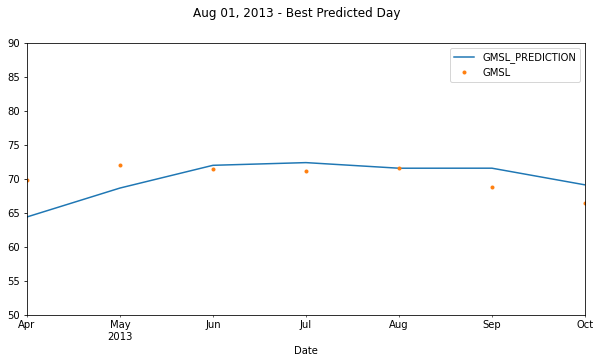

In [181]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = data_test[['GMSL_PREDICTION','GMSL']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(50, 90)
ax.set_xbound(lower='04-01-2013', upper='10-01-2013')
plot = plt.suptitle('Aug 01, 2013 - Best Predicted Day')